In [9]:
accuracy_scores = {
    'densenet169': -1,
    'vgg16': -1,
    'resnet': -1,
    'mobilenet': -1,
    'xception': -1,
    'dense': -1,
    'denser': -1,
    'CNN': -1,
    'CNN_more_capacity': -1
}

precision_scores = {
    'densenet169': -1,
    'vgg16': -1,
    'resnet': -1,
    'mobilenet': -1,
    'xception': -1,
    'dense': -1,
    'denser': -1,
    'CNN': -1,
    'CNN_more_capacity': -1
}

recall_scores = {
    'densenet169': -1,
    'vgg16': -1,
    'resnet': -1,
    'mobilenet': -1,
    'xception': -1,
    'dense': -1,
    'denser': -1,
    'CNN': -1,
    'CNN_more_capacity': -1
}

roc_auc_scores = {
    'densenet169': -1,
    'vgg16': -1,
    'resnet': -1,
    'mobilenet': -1,
    'xception': -1,
    'dense': -1,
    'denser': -1,
    'CNN': -1,
    'CNN_more_capacity': -1
}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = "../input/emotion-detection-fer/train"
test_dir = "../input/emotion-detection-fer/test"


CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]


<h1> DenseNet169 </h1>

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (48, 48),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (48, 48),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(48,48, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(48 ,48,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [6]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
densenet169 (Functional)     (None, 1, 1, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

In [7]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='densenet169.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)

history = pd.DataFrame(history.history)

Epoch 1/10
359/359 [==============================] - 247s 611ms/step - loss: 9.8556 - accuracy: 0.3334 - val_loss: 5.5712 - val_accuracy: 0.1752
Epoch 2/10
359/359 [==============================] - 70s 196ms/step - loss: 3.3427 - accuracy: 0.4822 - val_loss: 2.3583 - val_accuracy: 0.4585
Epoch 3/10
359/359 [==============================] - 71s 196ms/step - loss: 1.7695 - accuracy: 0.5265 - val_loss: 1.5849 - val_accuracy: 0.4936
Epoch 4/10
359/359 [==============================] - 71s 198ms/step - loss: 1.3662 - accuracy: 0.5529 - val_loss: 1.4956 - val_accuracy: 0.5001
Epoch 5/10
359/359 [==============================] - 71s 198ms/step - loss: 1.2478 - accuracy: 0.5703 - val_loss: 1.2245 - val_accuracy: 0.5722
Epoch 6/10
359/359 [==============================] - 70s 196ms/step - loss: 1.1881 - accuracy: 0.5909 - val_loss: 1.2183 - val_accuracy: 0.5753
Epoch 7/10
359/359 [==============================] - 71s 198ms/step - loss: 1.1526 - accuracy: 0.6024 - val_loss: 1.2558 - val_a

In [8]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 10 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='densenet169_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/10
359/359 [==============================] - 85s 203ms/step - loss: 1.0018 - accuracy: 0.6678 - val_loss: 1.0649 - val_accuracy: 0.6347
Epoch 2/10
359/359 [==============================] - 71s 199ms/step - loss: 0.9565 - accuracy: 0.6827 - val_loss: 1.0535 - val_accuracy: 0.6353
Epoch 3/10
359/359 [==============================] - 71s 197ms/step - loss: 0.9442 - accuracy: 0.6830 - val_loss: 1.0488 - val_accuracy: 0.6427
Epoch 4/10
359/359 [==============================] - 70s 195ms/step - loss: 0.9325 - accuracy: 0.6877 - val_loss: 1.0458 - val_accuracy: 0.6450
Epoch 5/10
359/359 [==============================] - 71s 197ms/step - loss: 0.9229 - accuracy: 0.6937 - val_loss: 1.0425 - val_accuracy: 0.6454
Epoch 6/10
359/359 [==============================] - 71s 197ms/step - loss: 0.9170 - accuracy: 0.6951 - val_loss: 1.0416 - val_accuracy: 0.6459
Epoch 7/10
359/359 [==============================] - 70s 196ms/step - loss: 0.9054 - accuracy: 0.6998 - val_loss: 1.0398 - val_ac

In [10]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 55s 488ms/step - loss: 1.0605 - accuracy: 0.6432


In [11]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       958
           1       0.00      0.00      0.00       111
           2       0.48      0.41      0.44      1024
           3       0.85      0.87      0.86      1774
           4       0.58      0.69      0.63      1233
           5       0.53      0.51      0.52      1247
           6       0.78      0.75      0.77       831

    accuracy                           0.64      7178
   macro avg       0.54      0.54      0.54      7178
weighted avg       0.63      0.64      0.64      7178



ROC AUC score: 0.9178967223435861


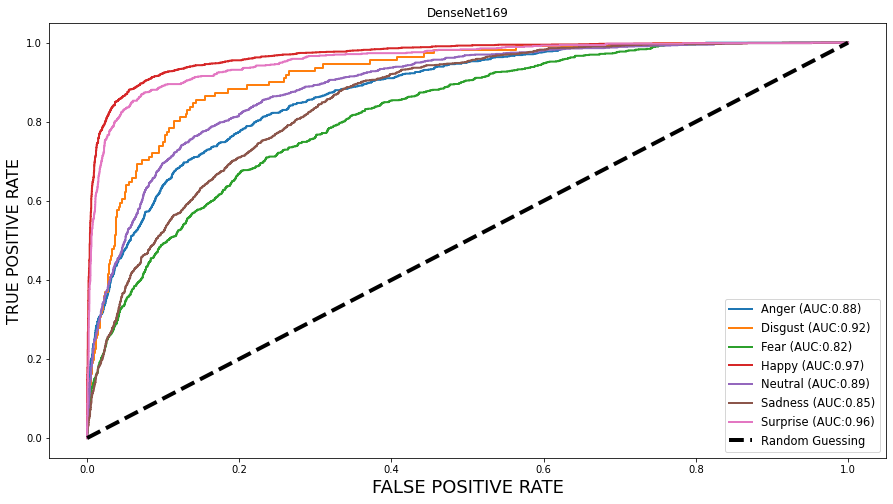

In [13]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("DenseNet169")
plt.legend(fontsize = 11.5)
plt.show()

In [14]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8973253883430486


In [22]:
print("Accuracy Score  = " ,accuracy_score(y_test , y_preds))

Accuracy Score  =  0.6432153803287823


In [26]:
print("Precision Score  = " ,precision_score(y_test , y_preds, average='macro'))

Precision Score  =  0.5362188492262413


In [27]:
print("Recall Score  = " ,recall_score(y_test , y_preds, average='macro'))

Recall Score  =  0.543098179683222


In [28]:
accuracy_scores['densenet169'] = accuracy_score(y_test , y_preds)
precision_scores['densenet169'] = precision_score(y_test , y_preds, average='macro')
recall_scores['densenet169'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['densenet169'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> VGG 16 </h1>

In [29]:
preprocess_fun = tf.keras.applications.vgg16.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (48, 48),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (48, 48),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [32]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.VGG16(input_shape=(48,48, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(48 ,48,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [33]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0   

In [34]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='vgg16.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 67s 180ms/step - loss: 9.4035 - accuracy: 0.2593 - val_loss: 4.9801 - val_accuracy: 0.3984
Epoch 2/10
359/359 [==============================] - 63s 174ms/step - loss: 3.4063 - accuracy: 0.3673 - val_loss: 2.2718 - val_accuracy: 0.4187
Epoch 3/10
359/359 [==============================] - 63s 175ms/step - loss: 1.8756 - accuracy: 0.4358 - val_loss: 1.5553 - val_accuracy: 0.4680
Epoch 4/10
359/359 [==============================] - 63s 175ms/step - loss: 1.4791 - accuracy: 0.4720 - val_loss: 1.3591 - val_accuracy: 0.4949
Epoch 5/10
359/359 [==============================] - 63s 176ms/step - loss: 1.3402 - accuracy: 0.5081 - val_loss: 1.2864 - val_accuracy: 0.5215
Epoch 6/10
359/359 [==============================] - 62s 173ms/step - loss: 1.2849 - accuracy: 0.5265 - val_loss: 1.2893 - val_accuracy: 0.5372
Epoch 7/10
359/359 [==============================] - 62s 173ms/step - loss: 1.2360 - accuracy: 0.5503 - val_loss: 1.1816 - val_ac

In [35]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 10 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='vgg16_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/10
359/359 [==============================] - 64s 176ms/step - loss: 1.0601 - accuracy: 0.6302 - val_loss: 1.1081 - val_accuracy: 0.6051
Epoch 2/10
359/359 [==============================] - 63s 175ms/step - loss: 1.0344 - accuracy: 0.6379 - val_loss: 1.0984 - val_accuracy: 0.6093
Epoch 3/10
359/359 [==============================] - 63s 176ms/step - loss: 1.0278 - accuracy: 0.6420 - val_loss: 1.0933 - val_accuracy: 0.6084
Epoch 4/10
359/359 [==============================] - 63s 176ms/step - loss: 1.0200 - accuracy: 0.6447 - val_loss: 1.0890 - val_accuracy: 0.6128
Epoch 5/10
359/359 [==============================] - 63s 176ms/step - loss: 1.0084 - accuracy: 0.6523 - val_loss: 1.0862 - val_accuracy: 0.6124
Epoch 6/10
359/359 [==============================] - 63s 175ms/step - loss: 1.0077 - accuracy: 0.6510 - val_loss: 1.0841 - val_accuracy: 0.6133
Epoch 7/10
359/359 [==============================] - 63s 176ms/step - loss: 1.0043 - accuracy: 0.6539 - val_loss: 1.0811 - val_ac

In [36]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 17s 155ms/step - loss: 1.0934 - accuracy: 0.6094


In [37]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.48      0.55      0.51       958
           1       0.00      0.00      0.00       111
           2       0.41      0.24      0.30      1024
           3       0.87      0.87      0.87      1774
           4       0.59      0.59      0.59      1233
           5       0.43      0.55      0.49      1247
           6       0.73      0.77      0.75       831

    accuracy                           0.61      7178
   macro avg       0.50      0.51      0.50      7178
weighted avg       0.60      0.61      0.60      7178



ROC AUC score: 0.9079408138465669


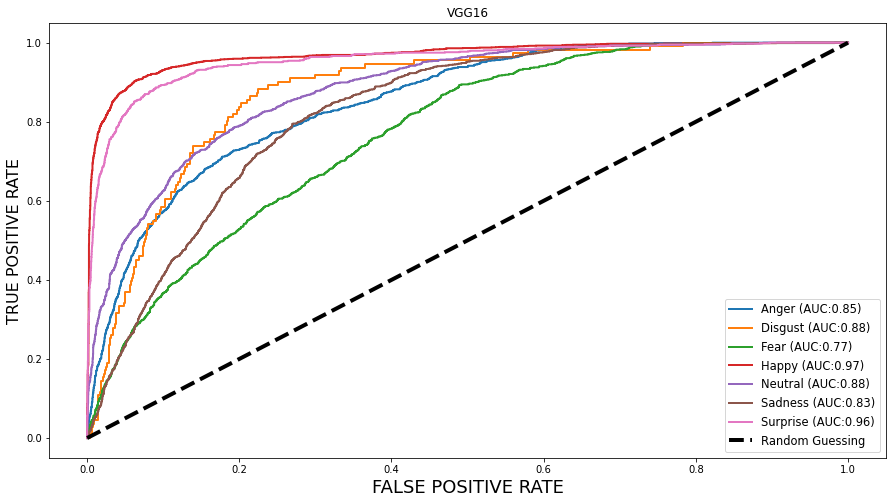

In [38]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("VGG16")
plt.legend(fontsize = 11.5)
plt.show()

In [41]:
accuracy_scores['vgg16'] = accuracy_score(y_test , y_preds)
precision_scores['vgg16'] = precision_score(y_test , y_preds, average='macro')
recall_scores['vgg16'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['vgg16'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> Resnet50 </h1>

In [42]:
preprocess_fun = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (48, 48),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (48, 48),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [43]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(48,48, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(48 ,48,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [44]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0   

In [45]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 75s 193ms/step - loss: 9.9004 - accuracy: 0.3621 - val_loss: 5.7451 - val_accuracy: 0.1427
Epoch 2/10
359/359 [==============================] - 67s 186ms/step - loss: 3.3404 - accuracy: 0.5067 - val_loss: 2.5011 - val_accuracy: 0.4036
Epoch 3/10
359/359 [==============================] - 67s 186ms/step - loss: 1.7501 - accuracy: 0.5455 - val_loss: 1.4732 - val_accuracy: 0.5475
Epoch 4/10
359/359 [==============================] - 66s 183ms/step - loss: 1.3392 - accuracy: 0.5743 - val_loss: 1.3208 - val_accuracy: 0.5485
Epoch 5/10
359/359 [==============================] - 66s 183ms/step - loss: 1.2153 - accuracy: 0.5903 - val_loss: 1.2752 - val_accuracy: 0.5560
Epoch 6/10
359/359 [==============================] - 66s 184ms/step - loss: 1.1595 - accuracy: 0.6053 - val_loss: 1.2184 - val_accuracy: 0.5867
Epoch 7/10
359/359 [==============================] - 66s 184ms/step - loss: 1.1291 - accuracy: 0.6178 - val_loss: 1.1744 - val_ac

In [46]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 5 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/5
359/359 [==============================] - 72s 188ms/step - loss: 1.0325 - accuracy: 0.6560 - val_loss: 1.1003 - val_accuracy: 0.6192
Epoch 2/5
359/359 [==============================] - 67s 187ms/step - loss: 1.0071 - accuracy: 0.6664 - val_loss: 1.0930 - val_accuracy: 0.6218
Epoch 3/5
359/359 [==============================] - 67s 185ms/step - loss: 0.9956 - accuracy: 0.6671 - val_loss: 1.0888 - val_accuracy: 0.6236
Epoch 4/5
359/359 [==============================] - 69s 192ms/step - loss: 0.9906 - accuracy: 0.6678 - val_loss: 1.0856 - val_accuracy: 0.6257
Epoch 5/5
359/359 [==============================] - 67s 187ms/step - loss: 0.9793 - accuracy: 0.6718 - val_loss: 1.0815 - val_accuracy: 0.6286


In [47]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 19s 164ms/step - loss: 1.0992 - accuracy: 0.6258


In [48]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55       958
           1       0.00      0.00      0.00       111
           2       0.49      0.35      0.41      1024
           3       0.85      0.84      0.84      1774
           4       0.54      0.69      0.60      1233
           5       0.52      0.50      0.51      1247
           6       0.74      0.74      0.74       831

    accuracy                           0.63      7178
   macro avg       0.52      0.53      0.52      7178
weighted avg       0.62      0.63      0.62      7178



ROC AUC score: 0.9119163399366654


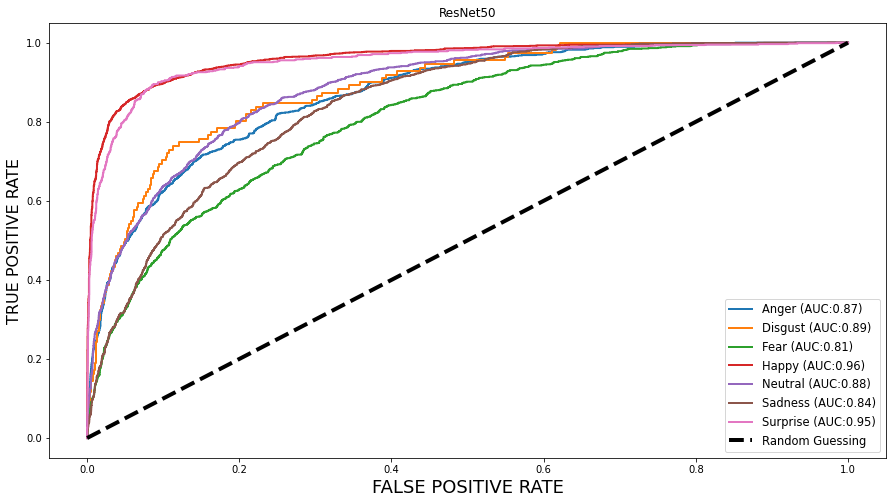

In [49]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("ResNet50")
plt.legend(fontsize = 11.5)
plt.show()

In [50]:
accuracy_scores['resnet'] = accuracy_score(y_test , y_preds)
precision_scores['resnet'] = precision_score(y_test , y_preds, average='macro')
recall_scores['resnet'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['resnet'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> MobileNet </h1>

In [51]:
preprocess_fun = tf.keras.applications.mobilenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48 ,48),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (48, 48),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (48, 48),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [52]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.MobileNet(input_shape=(48,48, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(48 ,48,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [53]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0   

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='mobilenet.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 68s 183ms/step - loss: 9.8068 - accuracy: 0.2682 - val_loss: 5.4558 - val_accuracy: 0.1820
Epoch 2/10
359/359 [==============================] - 64s 179ms/step - loss: 3.5054 - accuracy: 0.3931 - val_loss: 2.3561 - val_accuracy: 0.4426
Epoch 3/10
359/359 [==============================] - 64s 179ms/step - loss: 1.9416 - accuracy: 0.4461 - val_loss: 1.7306 - val_accuracy: 0.4369
Epoch 4/10
359/359 [==============================] - 63s 176ms/step - loss: 1.5312 - accuracy: 0.4767 - val_loss: 1.4566 - val_accuracy: 0.4781
Epoch 5/10
359/359 [==============================] - 64s 177ms/step - loss: 1.4051 - accuracy: 0.4986 - val_loss: 1.4012 - val_accuracy: 0.4804
Epoch 6/10
359/359 [==============================] - 63s 177ms/step - loss: 1.3442 - accuracy: 0.5200 - val_loss: 1.3000 - val_accuracy: 0.5269
Epoch 7/10
359/359 [==============================] - 64s 177ms/step - loss: 1.3124 - accuracy: 0.5315 - val_loss: 1.2983 - val_ac

In [55]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 5,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='mobilenet_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/5
359/359 [==============================] - 66s 179ms/step - loss: 1.1995 - accuracy: 0.5817 - val_loss: 1.1944 - val_accuracy: 0.5785
Epoch 2/5
359/359 [==============================] - 63s 177ms/step - loss: 1.1665 - accuracy: 0.5937 - val_loss: 1.1853 - val_accuracy: 0.5783
Epoch 3/5
359/359 [==============================] - 63s 176ms/step - loss: 1.1649 - accuracy: 0.5928 - val_loss: 1.1814 - val_accuracy: 0.5814
Epoch 4/5
359/359 [==============================] - 63s 176ms/step - loss: 1.1499 - accuracy: 0.5984 - val_loss: 1.1772 - val_accuracy: 0.5804
Epoch 5/5
359/359 [==============================] - 62s 174ms/step - loss: 1.1486 - accuracy: 0.5982 - val_loss: 1.1747 - val_accuracy: 0.5800


In [56]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 18s 159ms/step - loss: 1.1804 - accuracy: 0.5864


In [57]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.47      0.54      0.51       958
           1       0.00      0.00      0.00       111
           2       0.39      0.26      0.31      1024
           3       0.79      0.83      0.81      1774
           4       0.52      0.63      0.57      1233
           5       0.47      0.47      0.47      1247
           6       0.75      0.70      0.72       831

    accuracy                           0.59      7178
   macro avg       0.48      0.49      0.48      7178
weighted avg       0.57      0.59      0.58      7178



ROC AUC score: 0.8946953744611895


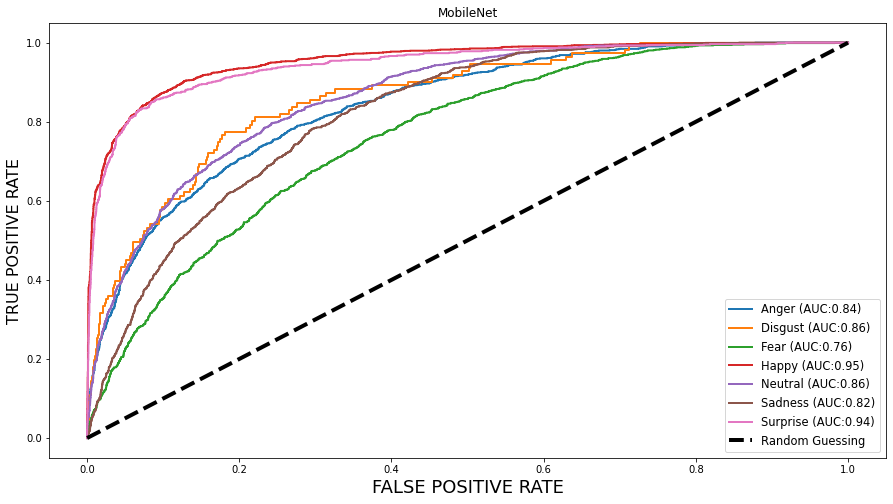

In [58]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("MobileNet")
plt.legend(fontsize = 11.5)
plt.show()

In [59]:
accuracy_scores['mobilenet'] = accuracy_score(y_test , y_preds)
precision_scores['mobilenet'] = precision_score(y_test , y_preds, average='macro')
recall_scores['mobilenet'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['mobilenet'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> Xception </h1>

In [63]:
preprocess_fun = tf.keras.applications.xception.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (128 ,128),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (128, 128),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (128, 128),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [64]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.Xception(input_shape=(128,128, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(128 ,128,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [65]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0   

In [66]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='xception.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 176s 474ms/step - loss: 9.8152 - accuracy: 0.3583 - val_loss: 5.3681 - val_accuracy: 0.3167
Epoch 2/10
359/359 [==============================] - 168s 467ms/step - loss: 3.3038 - accuracy: 0.5060 - val_loss: 2.1663 - val_accuracy: 0.5126
Epoch 3/10
359/359 [==============================] - 167s 463ms/step - loss: 1.6793 - accuracy: 0.5653 - val_loss: 1.4601 - val_accuracy: 0.5537
Epoch 4/10
359/359 [==============================] - 169s 470ms/step - loss: 1.2336 - accuracy: 0.6071 - val_loss: 1.2501 - val_accuracy: 0.5917
Epoch 5/10
359/359 [==============================] - 167s 463ms/step - loss: 1.0793 - accuracy: 0.6472 - val_loss: 1.2180 - val_accuracy: 0.5987
Epoch 6/10
359/359 [==============================] - 166s 461ms/step - loss: 0.9789 - accuracy: 0.6797 - val_loss: 1.1899 - val_accuracy: 0.5982
Epoch 7/10
359/359 [==============================] - 163s 454ms/step - loss: 0.9075 - accuracy: 0.7072 - val_loss: 1.1913 -

In [67]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 5 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='xception_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/5
359/359 [==============================] - 167s 454ms/step - loss: 0.6094 - accuracy: 0.8297 - val_loss: 1.1222 - val_accuracy: 0.6549
Epoch 2/5
359/359 [==============================] - 164s 456ms/step - loss: 0.5844 - accuracy: 0.8369 - val_loss: 1.1219 - val_accuracy: 0.6567
Epoch 3/5
359/359 [==============================] - 164s 457ms/step - loss: 0.5661 - accuracy: 0.8436 - val_loss: 1.1277 - val_accuracy: 0.6588
Epoch 4/5
359/359 [==============================] - 163s 452ms/step - loss: 0.5542 - accuracy: 0.8444 - val_loss: 1.1325 - val_accuracy: 0.6596
Epoch 5/5
359/359 [==============================] - 164s 456ms/step - loss: 0.5466 - accuracy: 0.8490 - val_loss: 1.1369 - val_accuracy: 0.6607
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [68]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 19s 170ms/step - loss: 1.1381 - accuracy: 0.6574


In [69]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57       958
           1       0.00      0.00      0.00       111
           2       0.50      0.48      0.49      1024
           3       0.89      0.85      0.87      1774
           4       0.61      0.65      0.63      1233
           5       0.53      0.58      0.55      1247
           6       0.80      0.77      0.79       831

    accuracy                           0.66      7178
   macro avg       0.55      0.56      0.56      7178
weighted avg       0.65      0.66      0.65      7178



ROC AUC score: 0.9162851592677262


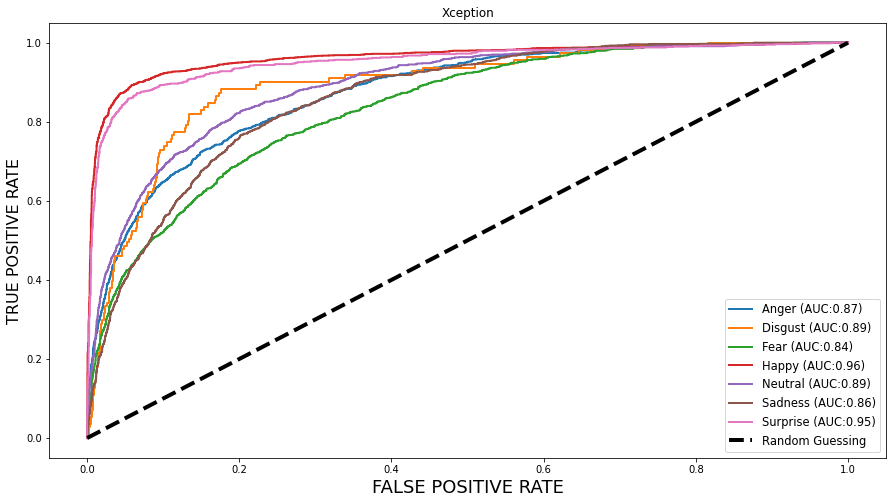

In [70]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("Xception")
plt.legend(fontsize = 11.5)
plt.show()

In [71]:
accuracy_scores['xception'] = accuracy_score(y_test , y_preds)
precision_scores['xception'] = precision_score(y_test , y_preds, average='macro')
recall_scores['xception'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['xception'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> InceptionV3 </h1>

In [75]:
preprocess_fun = tf.keras.applications.inception_v3.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (128 ,128),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (128, 128),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (128, 128),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [76]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(input_shape=(128,128, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(128 ,128,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [77]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0   

In [78]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='inceptionv3.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 164s 434ms/step - loss: 9.8178 - accuracy: 0.3588 - val_loss: 5.4618 - val_accuracy: 0.2888
Epoch 2/10
359/359 [==============================] - 145s 404ms/step - loss: 3.2776 - accuracy: 0.5049 - val_loss: 2.1857 - val_accuracy: 0.5142
Epoch 3/10
359/359 [==============================] - 144s 402ms/step - loss: 1.6789 - accuracy: 0.5674 - val_loss: 1.5978 - val_accuracy: 0.4888
Epoch 4/10
359/359 [==============================] - 144s 401ms/step - loss: 1.2599 - accuracy: 0.6040 - val_loss: 1.2966 - val_accuracy: 0.5781
Epoch 5/10
359/359 [==============================] - 144s 401ms/step - loss: 1.1235 - accuracy: 0.6280 - val_loss: 1.1752 - val_accuracy: 0.5985
Epoch 6/10
359/359 [==============================] - 144s 401ms/step - loss: 1.0418 - accuracy: 0.6553 - val_loss: 1.2669 - val_accuracy: 0.5637
Epoch 7/10
359/359 [==============================] - 144s 401ms/step - loss: 0.9946 - accuracy: 0.6743 - val_loss: 1.3079 -

In [79]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 5 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='inceptionv3_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/5
359/359 [==============================] - 158s 423ms/step - loss: 0.7796 - accuracy: 0.7576 - val_loss: 1.0424 - val_accuracy: 0.6656
Epoch 2/5
359/359 [==============================] - 143s 399ms/step - loss: 0.7516 - accuracy: 0.7713 - val_loss: 1.0373 - val_accuracy: 0.6668
Epoch 3/5
359/359 [==============================] - 144s 402ms/step - loss: 0.7369 - accuracy: 0.7732 - val_loss: 1.0351 - val_accuracy: 0.6678
Epoch 4/5
359/359 [==============================] - 144s 401ms/step - loss: 0.7220 - accuracy: 0.7785 - val_loss: 1.0348 - val_accuracy: 0.6708
Epoch 5/5
359/359 [==============================] - 145s 404ms/step - loss: 0.7071 - accuracy: 0.7866 - val_loss: 1.0373 - val_accuracy: 0.6718


In [80]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 20s 179ms/step - loss: 1.0497 - accuracy: 0.6641


In [81]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.53      0.59      0.56       958
           1       0.00      0.00      0.00       111
           2       0.54      0.43      0.48      1024
           3       0.88      0.88      0.88      1774
           4       0.62      0.66      0.64      1233
           5       0.54      0.59      0.56      1247
           6       0.78      0.79      0.78       831

    accuracy                           0.66      7178
   macro avg       0.55      0.56      0.56      7178
weighted avg       0.65      0.66      0.66      7178



ROC AUC score: 0.9250523199518628


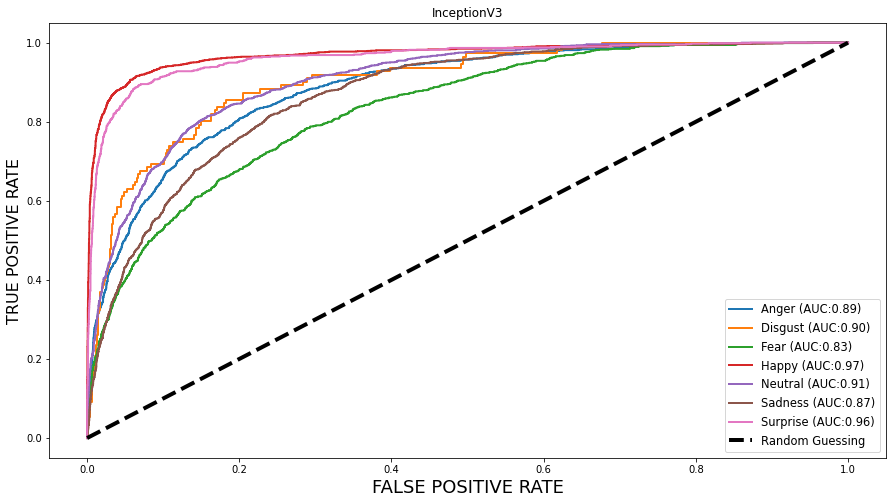

In [82]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("InceptionV3")
plt.legend(fontsize = 11.5)
plt.show()

In [83]:
accuracy_scores['inceptionv3'] = accuracy_score(y_test , y_preds)
precision_scores['inceptionv3'] = precision_score(y_test , y_preds, average='macro')
recall_scores['inceptionv3'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['inceptionv3'] = roc_auc_score(to_categorical(y_test) , preds)

<h1> EfficientNetB0 </h1>

In [84]:
preprocess_fun = tf.keras.applications.efficientnet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (128 ,128),
                                                    batch_size = 64,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (128, 128),
                                                         batch_size = 64,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (128, 128),
                                                    batch_size = 64,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [85]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.EfficientNetB0(input_shape=(128,128, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(7, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(128 ,128,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

In [86]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0   

In [87]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='efficientnetb0.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]

history = model.fit(x = train_generator,
                    epochs = 10,
                    validation_data = validation_generator , 
                    callbacks= callbacks)


Epoch 1/10
359/359 [==============================] - 158s 420ms/step - loss: 9.6642 - accuracy: 0.3767 - val_loss: 5.6038 - val_accuracy: 0.1702
Epoch 2/10
359/359 [==============================] - 148s 412ms/step - loss: 3.2608 - accuracy: 0.5111 - val_loss: 2622.2390 - val_accuracy: 0.1967
Epoch 3/10
359/359 [==============================] - 149s 413ms/step - loss: 1.7026 - accuracy: 0.5537 - val_loss: 151.1092 - val_accuracy: 0.1822
Epoch 4/10
359/359 [==============================] - 148s 411ms/step - loss: 1.2956 - accuracy: 0.5852 - val_loss: 2.5750 - val_accuracy: 0.1705
Epoch 5/10
359/359 [==============================] - 151s 420ms/step - loss: 1.1654 - accuracy: 0.6036 - val_loss: 951.2432 - val_accuracy: 0.1326
Epoch 6/10
359/359 [==============================] - 149s 415ms/step - loss: 1.0887 - accuracy: 0.6323 - val_loss: 51.7291 - val_accuracy: 0.1719
Epoch 7/10
359/359 [==============================] - 147s 410ms/step - loss: 1.0428 - accuracy: 0.6498 - val_loss: 

In [88]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.SGD(0.001), #lower learning rate
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

history_ = model.fit(x = train_generator,epochs = 5 ,validation_data = validation_generator, callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='efficientnetb0_finetuned.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=3,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )
]
)

Epoch 1/5
359/359 [==============================] - 167s 445ms/step - loss: 0.8773 - accuracy: 0.7198 - val_loss: 1.0306 - val_accuracy: 0.6544
Epoch 2/5
359/359 [==============================] - 148s 413ms/step - loss: 0.8519 - accuracy: 0.7306 - val_loss: 1.0264 - val_accuracy: 0.6593
Epoch 3/5
359/359 [==============================] - 146s 407ms/step - loss: 0.8450 - accuracy: 0.7305 - val_loss: 1.0192 - val_accuracy: 0.6642
Epoch 4/5
359/359 [==============================] - 147s 409ms/step - loss: 0.8294 - accuracy: 0.7360 - val_loss: 1.0181 - val_accuracy: 0.6635
Epoch 5/5
359/359 [==============================] - 147s 408ms/step - loss: 0.8268 - accuracy: 0.7343 - val_loss: 1.0178 - val_accuracy: 0.6614


In [89]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 20s 175ms/step - loss: 1.0442 - accuracy: 0.6594


In [90]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58       958
           1       0.00      0.00      0.00       111
           2       0.53      0.37      0.44      1024
           3       0.87      0.87      0.87      1774
           4       0.61      0.70      0.65      1233
           5       0.52      0.57      0.55      1247
           6       0.77      0.77      0.77       831

    accuracy                           0.66      7178
   macro avg       0.55      0.56      0.55      7178
weighted avg       0.65      0.66      0.65      7178



ROC AUC score: 0.9244838499902298


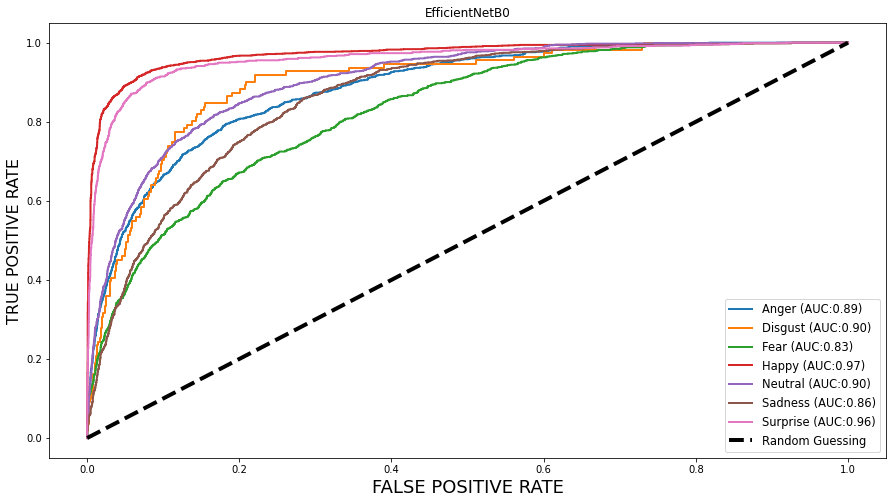

In [91]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.title("EfficientNetB0")
plt.legend(fontsize = 11.5)
plt.show()

In [92]:
accuracy_scores['efficientnetb0'] = accuracy_score(y_test , y_preds)
precision_scores['efficientnetb0'] = precision_score(y_test , y_preds, average='macro')
recall_scores['efficientnetb0'] = recall_score(y_test , y_preds, average='macro')
roc_auc_scores['efficientnetb0'] = roc_auc_score(to_categorical(y_test) , preds)

In [94]:
accuracy_scores

{'densenet169': 0.6432153803287823,
 'vgg16': 0.6093619392588465,
 'resnet': 0.6258010587907495,
 'mobilenet': 0.5863750348286431,
 'xception': 0.6574254667038172,
 'dense': -1,
 'denser': -1,
 'CNN': -1,
 'CNN_more_capacity': -1,
 'inceptionv3': 0.6641125661744218,
 'efficientnetb0': 0.659375870716077}

In [95]:
precision_scores

{'densenet169': 0.5362188492262413,
 'vgg16': 0.5012873517257298,
 'resnet': 0.5214809041487655,
 'mobilenet': 0.48413988867160246,
 'xception': 0.5538318458372451,
 'dense': -1,
 'denser': -1,
 'CNN': -1,
 'CNN_more_capacity': -1,
 'inceptionv3': 0.5548283578954746,
 'efficientnetb0': 0.5506967315626404}

In [96]:
recall_scores

{'densenet169': 0.543098179683222,
 'vgg16': 0.5107697925760082,
 'resnet': 0.5288647243904757,
 'mobilenet': 0.4909926639838346,
 'xception': 0.5587636595888913,
 'dense': -1,
 'denser': -1,
 'CNN': -1,
 'CNN_more_capacity': -1,
 'inceptionv3': 0.5625437182438884,
 'efficientnetb0': 0.5574425513203988}

In [97]:
roc_auc_scores

{'densenet169': 0.8973253883430486,
 'vgg16': 0.8759146421878709,
 'resnet': 0.8873855706102941,
 'mobilenet': 0.8635163396755503,
 'xception': 0.895623797076061,
 'dense': -1,
 'denser': -1,
 'CNN': -1,
 'CNN_more_capacity': -1,
 'inceptionv3': 0.9040391487974527,
 'efficientnetb0': 0.9015222431638137}

In [98]:
del accuracy_scores['dense']
del accuracy_scores['denser']
del accuracy_scores['CNN']
del accuracy_scores['CNN_more_capacity']

In [99]:
del precision_scores['dense']
del precision_scores['denser']
del precision_scores['CNN']
del precision_scores['CNN_more_capacity']

In [100]:
del recall_scores['dense']
del recall_scores['denser']
del recall_scores['CNN']
del recall_scores['CNN_more_capacity']

In [101]:
del roc_auc_scores['dense']
del roc_auc_scores['denser']
del roc_auc_scores['CNN']
del roc_auc_scores['CNN_more_capacity']

In [103]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [104]:
accuracy_scores.keys()

dict_keys(['densenet169', 'vgg16', 'resnet', 'mobilenet', 'xception', 'inceptionv3', 'efficientnetb0'])

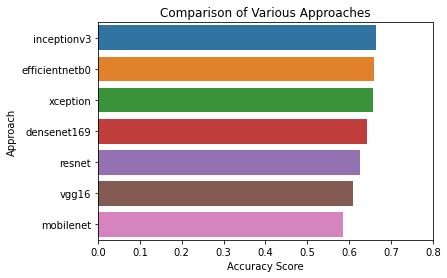

In [109]:
keys = list(accuracy_scores.keys())
values = list(accuracy_scores.values())
sorted_value_index = np.argsort(values)
sorted_results = {keys[i]: values[i] for i in sorted_value_index}

results_y = list(sorted_results.keys())
results_x = list(sorted_results.values())

results_y.reverse()
results_x.reverse()

fig, ax = plt.subplots()

sns.barplot(x=results_x, y=results_y, ax=ax)

ax.set_title("Comparison of Various Approaches")
ax.set_xlabel("Accuracy Score")
ax.set_ylabel("Approach")

ax.set_xlim((0, 0.8))

plt.show()

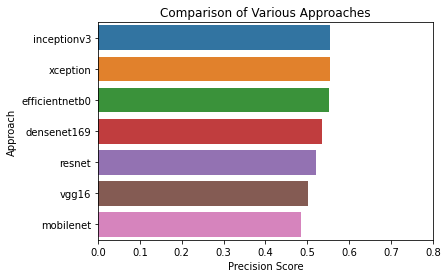

In [110]:
keys = list(precision_scores.keys())
values = list(precision_scores.values())
sorted_value_index = np.argsort(values)
sorted_results = {keys[i]: values[i] for i in sorted_value_index}

results_y = list(sorted_results.keys())
results_x = list(sorted_results.values())

results_y.reverse()
results_x.reverse()

fig, ax = plt.subplots()

sns.barplot(x=results_x, y=results_y, ax=ax)

ax.set_title("Comparison of Various Approaches")
ax.set_xlabel("Precision Score")
ax.set_ylabel("Approach")

ax.set_xlim((0, 0.8))

plt.show()

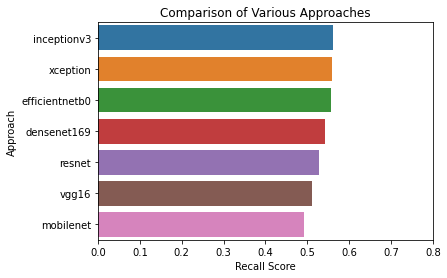

In [111]:
keys = list(recall_scores.keys())
values = list(recall_scores.values())
sorted_value_index = np.argsort(values)
sorted_results = {keys[i]: values[i] for i in sorted_value_index}

results_y = list(sorted_results.keys())
results_x = list(sorted_results.values())

results_y.reverse()
results_x.reverse()

fig, ax = plt.subplots()

sns.barplot(x=results_x, y=results_y, ax=ax)

ax.set_title("Comparison of Various Approaches")
ax.set_xlabel("Recall Score")
ax.set_ylabel("Approach")

ax.set_xlim((0, 0.8))

plt.show()

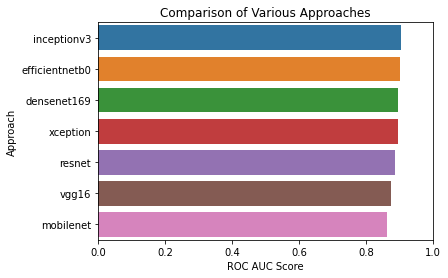

In [113]:
keys = list(roc_auc_scores.keys())
values = list(roc_auc_scores.values())
sorted_value_index = np.argsort(values)
sorted_results = {keys[i]: values[i] for i in sorted_value_index}

results_y = list(sorted_results.keys())
results_x = list(sorted_results.values())

results_y.reverse()
results_x.reverse()

fig, ax = plt.subplots()

sns.barplot(x=results_x, y=results_y, ax=ax)

ax.set_title("Comparison of Various Approaches")
ax.set_xlabel("ROC AUC Score")
ax.set_ylabel("Approach")

ax.set_xlim((0, 1))

plt.show()